# Neural Bag of Words
<img src="imgs/01.nbow-intro.png" width="800" height="800" />

## Why NBoW?
- **A classic “Hello World” task for NLP.**  
  Neural Bag-of-Words (NBoW) provides a simple yet effective baseline model for text classification, making it an ideal starting point for understanding core NLP concepts.

- **Introduction to sentiment analysis.**  
  In this tutorial, we build a machine learning model for *sentiment analysis*, a fundamental subtask of text classification.  
  The objective is to determine whether a given sentence or review expresses **positive** or **negative** sentiment.

- **Real-world dataset: IMDb movie reviews.**  
  The model is trained and evaluated on the widely used Internet Movie Database (IMDb) dataset, which contains labeled movie reviews.

- **Foundational NLP concepts.**  
  Along the way, essential techniques are introduced and explained, including:
  - Tokenization  
  - Vocabulary construction  
  - Numerical encoding of text  
  - Word embeddings  

## Global and imports settings

In [1]:
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
import requests
import zipfile
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import collections

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

## Dataset Preparation

- **Load the dataset** using the `datasets` library.
- **Split the dataset** into training and test sets.
- **Inspect the data structure:**
  - Each sample consists of:
    - `text`: the movie review
    - `label`: the sentiment label  
      - `0` → negative review  
      - `1` → positive review

In [2]:
train_data_raw, test_data_raw = datasets.load_dataset("imdb", split=["train", "test"])
train_data_raw, test_data_raw

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [3]:
train_data_raw.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [4]:
train_data_raw[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

## Building the Input Tokenizer

- **Tokenization** converts raw, unstructured text into a sequence of smaller units (tokens) that machine learning models can process.
- Tokens may represent **words**, **subwords**, or **characters**, depending on the tokenizer design.
- This tutorial uses **word-level tokenization**.
- The `word_tokenize` function from the Natural Language Toolkit (NLTK) `tokenize` module splits text into:
  - individual words  
  - punctuation symbols (e.g., commas, periods)
- This step prepares textual data for downstream NLP tasks such as vocabulary construction and embedding lookup.

In [5]:
nltk.download('punkt_tab')
def get_tokens(text):
    return word_tokenize(text.lower())  # Tokenize and lowercase

text = "Hello, Mr. Smith! Isn't NLP cool?"
print("Tokenizer: ", word_tokenize(text))  
print("Split: ", text.split()) 

Tokenizer:  ['Hello', ',', 'Mr.', 'Smith', '!', 'Is', "n't", 'NLP', 'cool', '?']
Split:  ['Hello,', 'Mr.', 'Smith!', "Isn't", 'NLP', 'cool?']


[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Applying the Tokenizer: Mapping Input Text to Tokens

- **Preprocess the dataset** by applying the tokenizer to both the training and test splits.
- Convert raw text into sequences of tokens that can be used for vocabulary construction and model input.

In [6]:
max_length = 256

def tokenize_input(input, max_length):
    tokens = get_tokens(input["text"])[:max_length] # truncate text if too long
    return {"tokens": tokens}
    
train_data_tok = train_data_raw.map(
    tokenize_input, fn_kwargs={"max_length": max_length}
)
test_data_tok = test_data_raw.map(
    tokenize_input, fn_kwargs={"max_length": max_length}
)

- **`tokenize_input`** is a helper function that applies a tokenizer to textual data from the dataset. Its main purposes are:
  - **Tokenize text:** convert raw text into a sequence of tokens.
  - **Truncate long sequences:** limit tokenized output to a specified `max_length`.

In [7]:
train_data_tok

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 25000
})

In [8]:
train_data_tok.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [9]:
train_data_tok[0]["tokens"][:25]

['i',
 'rented',
 'i',
 'am',
 'curious-yellow',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967.',
 'i']

## Building Vocabulary

* **Numerical Foundation**: Neural networks process numbers (tensors), not raw text.
* **NBow Vocabulary Mapping**: Maps each unique token to a unique integer index.
* **Corpus Analysis**: Builds the vocabulary by calculating token frequencies across the training set.
* **Generalization via Filtering**: Removes rare tokens (below min_freq) to reduce noise and prevent overfitting.
* **Special Tokens**: Integrates reserved tokens for <UNK> (out-of-vocabulary) and <PAD> (sequence length normalization). 

In [10]:
# Building Vocabulary: Mapping word → unique ID
all_tokens = [token for example in train_data_tok for token in example["tokens"]]
word_counts = Counter(all_tokens)  # Count word occurrences

# Assign unique IDs (starting from 2 to reserve 0 for PAD, 1 for UNK)
min_freq = 5

word_counts_filtered = {x: count for x, count in word_counts.items() if count >= min_freq}

vocab = {word: idx + 2 for idx, word in enumerate(word_counts_filtered) }
pad_token_index = 0
unknown_token_index = 1
vocab["[PAD]"] = pad_token_index  # Padding token
vocab["[UNK]"] = unknown_token_index  # Unknown token

# Print vocabulary size
print(f"Vocabulary Size: {len(vocab)}")

# Print first 10 words in vocabulary
print(list(vocab.keys())[500:510])

Vocabulary Size: 25607
['themselves', 'jr.', 'how', 'filmmakers', 'hard', 'seems', 'awfully', 'sloppy', 'saw', 'glimpse']


## Applying the Vocabulary to Text Tokens

- Convert tokenized text into numerical representations using the constructed vocabulary.
- Map each token to its corresponding integer index, producing a numerical vector suitable for model input.

In [11]:
def numericalize_dataset(example, vocab):
    """
    Convert tokenized text into a list of vocabulary indices.
    Unknown tokens are mapped to the <UNK> token index.
    """
    # Map each token to its integer ID (fallback to UNK if not in vocab)
    token_ids = [vocab.get(token, unknown_token_index)
                 for token in example["tokens"]]

    return {"ids": token_ids}


# Apply numericalization to train and test datasets
train_data_num = train_data_tok.map(
    numericalize_dataset, fn_kwargs={"vocab": vocab}
)

test_data_num = test_data_tok.map(
    numericalize_dataset, fn_kwargs={"vocab": vocab}
)

In [12]:
# Print the first example before and after tokenization
original_text = train_data_num[0]["text"]  # Get original text
tokenized_ids = train_data_num[0]["ids"]  # Get tokenized input IDs

vocab_inv = {v: k for k, v in vocab.items()}  # Invert mapping
tokenized_text = [vocab_inv.get(token, "[UNK]") for token in tokenized_ids]
print(f"Original Text:\n{original_text}\n")
print(f"Tokens:\n{tokenized_text}\n")
print(f"Token IDS:\n{tokenized_ids}\n")

Original Text:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and f

In [13]:
train_data_tensor = train_data_num.with_format(type="torch", columns=["ids", "label"])
test_data_tensor = test_data_num.with_format(type="torch", columns=["ids", "label"])

## Building dataloader

### Custom Collation Function for Variable-Length Sequences

- The **`get_collate_fn`** function defines a custom collation function for PyTorch’s `DataLoader` to process batches containing variable-length input sequences.
- The collation process handles differing sequence lengths by:
  - **Padding sequences** so that all inputs in the batch match the length of the longest sequence
  - **Stacking labels** into a single tensor
```
[
  {"ids": tensor([5, 9, 2]),     "label": tensor(1)},
  {"ids": tensor([3, 4]),        "label": tensor(0)},
  {"ids": tensor([7, 8, 6, 1]),  "label": tensor(1)}
]
```
-->
```
{
  "ids": tensor([
      [5, 9, 2, 0],
      [3, 4, 0, 0],
      [7, 8, 6, 1]
  ]),
  "label": tensor([1, 0, 1])
}
```

In [14]:
def get_collate_fn(pad_token_index):
    def collate_fn(batch):
        
        # Extract token ID sequences and labels from each sample
        ids = [item["ids"] for item in batch]
        labels = [item["label"] for item in batch]

        # Pad sequences so all have equal length within the batch
        # Shape: [batch_size, max_sequence_length]
        ids = nn.utils.rnn.pad_sequence(
            ids, batch_first=True, padding_value=pad_token_index
        )
        labels = torch.stack(labels)

        return {"ids": ids, "label": labels}

    return collate_fn

### DataLoader Construction

- **`get_data_loader`** creates a PyTorch `DataLoader` configured to handle batches of variable-length input sequences.
- The function wraps PyTorch’s standard `DataLoader` while integrating a **custom collation function** produced by `get_collate_fn`.
- This custom collation logic ensures that:
  - Input sequences of differing lengths are padded consistently within each batch
  - Labels are correctly stacked into a single tensor
- By encapsulating this behavior, `get_data_loader` provides a clean and reusable interface for batch preparation while maintaining compatibility with PyTorch’s training and evaluation workflows.

In [15]:
def get_data_loader(dataset, batch_size, pad_token_index, shuffle=False):
    collate_fn = get_collate_fn(pad_token_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [16]:
batch_size = 512

train_data_loader = get_data_loader(train_data_tensor, batch_size, pad_token_index, shuffle=True)
test_data_loader = get_data_loader(test_data_tensor, batch_size, pad_token_index)

## Building the Network with PyTorch

<img src="imgs/nbow_model.png" width="800" height="800" />
A simple neural network for text classification that treats input text as an unordered set of words (bag-of-words representation).

In [17]:
class NBoW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_token_index):
        super().__init__()
        # Embedding layer:
        # Maps each token ID -> embedding vector
        # padding_idx ensures that embeddings for PAD tokens are always zero
        self.embedding = nn.Embedding(
            vocab_size, 
            embedding_dim, 
            padding_idx=pad_token_index
        )
        
        # Fully-connected (linear) layer:
        # Maps embedding_dim -> output_dim (e.g., number of classes)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, ids):
        # Convert token IDs into embeddings
        # Result shape: [batch_size, sequence_length, embedding_dim]
        embedded = self.embedding(ids)
        
        # Pool across the sequence dimension using mean
        # This collapses variable-length sequences into a single vector
        # Result shape: [batch_size, embedding_dim]
        pooled = embedded.mean(dim=1)
        
        # Apply linear layer to get class scores (logits)
        prediction = self.fc(pooled)
        
        # Result shape: [batch_size, output_dim]
        return prediction

## Neural Bag-of-Words (NBoW) Model

The **Neural Bag-of-Words (NBoW)** model is a simple yet effective baseline architecture for text classification. It represents a document as the average of its word embeddings and uses a linear classifier to predict class labels.

### Embedding Layer

- Maps discrete token IDs to continuous, dense vector representations.
- Learns semantic relationships between words during training.
- The `padding_idx` parameter ensures that embeddings corresponding to padding tokens remain zero and do not influence the pooled representation.
- Output shape:  
  `[batch_size, sequence_length, embedding_dim]`

### Mean Pooling (Bag-of-Words Representation)

- Aggregates token embeddings by computing their mean across the sequence dimension.
- Converts variable-length input sequences into fixed-size document representations.
- Disregards word order, focusing on overall word presence and distribution.
- Provides an efficient and robust representation for baseline text classification.
- Shape transformation:  
  `[batch_size, seq_len, embedding_dim] → [batch_size, embedding_dim]`

### Linear Classifier

- Applies a fully connected layer to the pooled document embedding.
- Projects the embedding into a space of class logits.
- The number of output dimensions corresponds to the number of target classes (e.g., `2` for binary sentiment classification).
- Output shape:  
  `[batch_size, output_dim]`

### Summary

- The NBoW model offers a strong and computationally efficient baseline for text classification tasks.
- Its simplicity enables fast training and clear interpretability.
- By ignoring word order and contextual dependencies, the model trades expressiveness for efficiency, making it ideal for introductory experiments and baseline comparisons.

In [18]:
vocab_size = len(vocab)
embedding_dim = 300
output_dim = len(train_data_tensor.unique("label"))

model = NBoW(vocab_size, embedding_dim, output_dim, pad_token_index)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

for name, param in model.named_parameters():
    print(name, param.shape, param.requires_grad)

The model has 7,682,702 trainable parameters
embedding.weight torch.Size([25607, 300]) True
fc.weight torch.Size([2, 300]) True
fc.bias torch.Size([2]) True


### Download pre-trained embedding
* Code just downloads archive and unarchives desired dimensionality.
* Pretrained embedding capture simularities, e.g. if words are similar then cosine is -> 1
```
             king    france  computer
king     1.000000  0.345671  0.123456
queen    0.856734  0.234567  0.098765
prince   0.823456  0.287654  0.087654
...          ...       ...       ...
france   0.345671  1.000000  0.056789
germany  0.301234  0.912345  0.043210
paris    0.287654  0.876543  0.065432
...          ...       ...       ...
computer 0.123456  0.056789  1.000000
software 0.098765  0.043210  0.876543
keyboard 0.087654  0.032109  0.812345
````

In [19]:
def download_glove(dim=100, save_dir="glove"):
    assert dim in [50, 100, 200, 300], "Invalid dimension. Must be one of [50, 100, 200, 300]"
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    zip_path = os.path.join(save_dir, "glove.6B.zip")
    target_file = f"glove.6B.{dim}d.txt"
    target_path = os.path.join(save_dir, target_file)

    os.makedirs(save_dir, exist_ok=True)

    if not os.path.exists(target_path):
        if not os.path.exists(zip_path):
            print("Downloading GloVe embeddings...")
            response = requests.get(url, stream=True)
            total_size = int(response.headers.get('content-length', 0))
            with open(zip_path, "wb") as f, tqdm(
                desc=zip_path,
                total=total_size,
                unit="B",
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
                for data in response.iter_content(chunk_size=1024):
                    f.write(data)
                    bar.update(len(data))

        print("Extracting...")
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extract(target_file, path=save_dir)

    print(f"GloVe {dim}d embedding ready at: {target_path}")
    return target_path

# Example usage:
glove_path = download_glove(dim=embedding_dim)

GloVe 300d embedding ready at: glove/glove.6B.300d.txt


### Load embedding matrix into the model

In [20]:
# Load GloVe embeddings
def load_glove_embeddings(filepath):
    embeddings = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings(glove_path)

# Average GloVe vector (for OOV tokens)
avg_glove_embedding = np.mean(
    np.stack(list(glove_embeddings.values())), axis=0
)

# Create embedding matrix
embedding_matrix = np.zeros((len(vocab), embedding_dim), dtype=np.float32)

for token, idx in vocab.items():
    if token in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[token]
    else:
        embedding_matrix[idx] = avg_glove_embedding

# Convert to PyTorch tensor
embedding_matrix = torch.tensor(embedding_matrix)

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: torch.Size([25607, 300])


In [21]:
# Convert the embedding matrix to a PyTorch tensor
embedding_matrix = embedding_matrix.clone().detach().float()

# Assign to the model's embedding layer
model.embedding.weight.data.copy_(embedding_matrix)
print("GloVe embeddings loaded into the model.")

GloVe embeddings loaded into the model.


## Building Training Pipeline

In [22]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

### Adaptive Learning Rates (ADAM):
* Adam automatically adjusts learning rates for each parameter (using momentum and adaptive scaling), which:
* Works well with sparse gradients (common in NLP)
* Eliminates need for manual learning rate scheduling
* Outperforms SGD for most NLP tasks

### Output Layer Behavior:
* The final layer produces raw logits (unnormalized scores)
* This is the required input format for nn.CrossEntropyLoss
* The loss function internally applies LogSoftmax + NLLLoss
```
# Equivalent to:
log_probs = F.log_softmax(model(inputs), dim=1)
loss = F.nll_loss(log_probs, labels)
```

Standard Practice:
* PyTorch classification models typically output raw logits
* This pattern is used in official tutorials and production code
* Simplifies the model architecture

### Training step

* *tqdm*: use tqdm to display a real-time progress bar during training, which provides valuable feedback about training progress, estimated time remaining, and batch processing speed. While you can use enumerate, tqdm offers significant usability advantages.

In [23]:
def get_accuracy(prediction, label):
    return (prediction.argmax(dim=-1) == label).float().mean()

In [24]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    losses, accs = [], []

    for batch in tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        preds = model(ids)
        loss = criterion(preds, labels)
        acc = get_accuracy(preds, labels)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accs.append(acc.item())

    return np.mean(losses), np.mean(accs)

### Test step

In [25]:
def evaluate(dl, model, loss_fn, device):
    model.eval()
    losses, accs = [], []

    with torch.no_grad():
        for b in tqdm(dl, desc="evaluating..."):
            x, y = b["ids"].to(device), b["label"].to(device)
            p = model(x)
            l = loss_fn(p, y)
            losses.append(l.item())
            accs.append(get_accuracy(p, y).item())

    return np.mean(losses), np.mean(accs)


## Model in the loop

In [26]:
n_epochs = 10
metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(train_data_loader, model, criterion, optimizer, device)
    test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["test_losses"].append(test_loss)
    metrics["test_accs"].append(test_acc)

    print(
        f"Epoch {epoch} | "
        f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f} | "
        f"Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}"
    )
torch.save(model.state_dict(), "nbow.pt")

evaluating...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 12.13it/s]


Epoch 0 | Train Loss: 0.673, Train Acc: 0.625 | Test Loss: 0.656, Test Acc: 0.672


evaluating...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.27it/s]


Epoch 1 | Train Loss: 0.618, Train Acc: 0.721 | Test Loss: 0.594, Test Acc: 0.730


evaluating...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 11.68it/s]


Epoch 2 | Train Loss: 0.537, Train Acc: 0.786 | Test Loss: 0.520, Test Acc: 0.787


evaluating...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 11.85it/s]


Epoch 3 | Train Loss: 0.454, Train Acc: 0.833 | Test Loss: 0.458, Test Acc: 0.819


evaluating...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 10.50it/s]


Epoch 4 | Train Loss: 0.388, Train Acc: 0.862 | Test Loss: 0.416, Test Acc: 0.836


evaluating...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.45it/s]


Epoch 5 | Train Loss: 0.340, Train Acc: 0.880 | Test Loss: 0.388, Test Acc: 0.844


evaluating...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 12.77it/s]


Epoch 6 | Train Loss: 0.304, Train Acc: 0.894 | Test Loss: 0.368, Test Acc: 0.852


evaluating...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.30it/s]


Epoch 7 | Train Loss: 0.275, Train Acc: 0.905 | Test Loss: 0.355, Test Acc: 0.856


evaluating...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.13it/s]


Epoch 8 | Train Loss: 0.252, Train Acc: 0.915 | Test Loss: 0.341, Test Acc: 0.861


evaluating...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 12.33it/s]


Epoch 9 | Train Loss: 0.232, Train Acc: 0.922 | Test Loss: 0.337, Test Acc: 0.862


### Performance during training

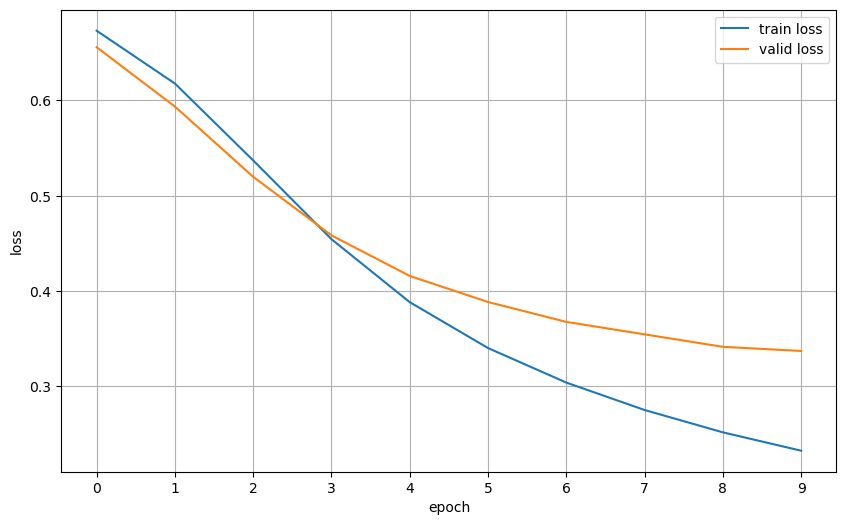

In [27]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["test_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

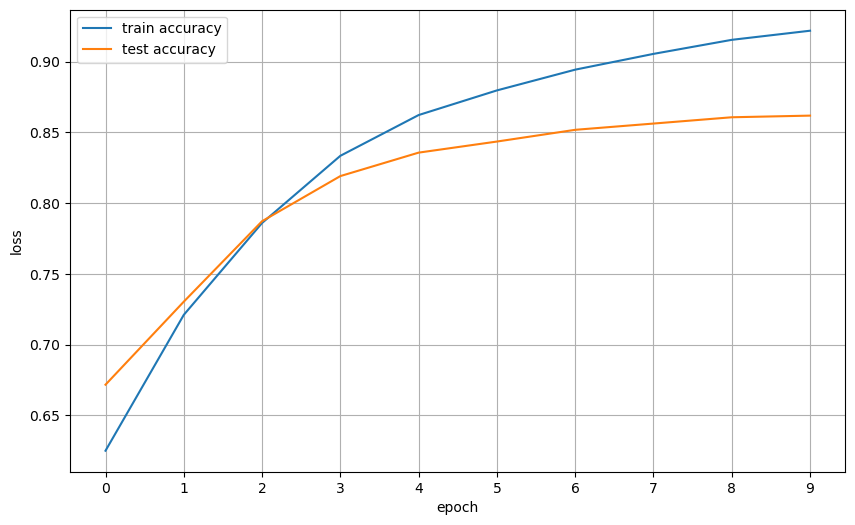

In [28]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["test_accs"], label="test accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

## Usage of trained model

In [29]:
model.load_state_dict(torch.load("nbow.pt", weights_only=True))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 12.90it/s]


In [30]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.337, test_acc: 0.862


In [31]:
def predict_sentiment(text, model, vocab, device):
    """
    Predict sentiment (positive/negative) for a single text string.

    Returns:
        predicted_class (int): 0 = negative, 1 = positive
        predicted_probability (float): confidence of the prediction
    """

    # Put model in evaluation mode
    model.eval()

    # Tokenize input text
    tokens = get_tokens(text)

    # Convert tokens to vocabulary indices (use [UNK] or 0 for unknown words)
    ids = [vocab.get(tok, vocab.get("[UNK]", 0)) for tok in tokens]

    # Convert to tensor and add batch dimension: [1, seq_len]
    ids = torch.LongTensor(ids).unsqueeze(0).to(device)

    # Disable gradient tracking for inference
    with torch.no_grad():
        logits = model(ids).squeeze(0)          # [num_classes]
        probs = torch.softmax(logits, dim=-1)   # convert to probabilities

    # Get predicted class and its probability
    pred_class = logits.argmax().item()
    pred_prob = probs[pred_class].item()

    # Map class index to label
    sentiment = "pos" if pred_class == 1 else "neg"

    print(f"Sentiment: {sentiment} ({pred_prob:.4f})")

    return pred_class, pred_prob


In [32]:
text = "This film is terrible!"

predict_sentiment(text, model, vocab, device)

Sentiment: neg (1.0000)


(0, 0.9999996423721313)

In [33]:
text = "This film is great!"

predict_sentiment(text, model, vocab, device)

Sentiment: pos (1.0000)


(1, 1.0)

In [34]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, vocab, device)

Sentiment: pos (0.7698)


(1, 0.7698222398757935)

In [35]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, vocab, device)

Sentiment: pos (0.7698)


(1, 0.7698222398757935)